# Predicting the S&P 500 Index

## Introduction

In this project, I will be using historical data of the price of the S&P500 Index to make prediction about future prices to help forecast how the stock market as a whole will perform. Creating a predictive model could allow traders to make money on the stock market.

I will be working with a csv file containing historical index prices. Each row in this file contains a daily record of the price of teh S&P500 Index from 1950 to 2015. 

The columns of the dataset are:

Date -- The date of the record.
Open -- The opening price of the day (when trading starts).
High -- The highest trade price during the day.
Low -- The lowest trade price during the day.
Close -- The closing price for the day (when trading is finished).
Volume -- The number of shares traded.
Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. 

I will be using this dataset to develop a predictive model. I will train the model with data from 1950-2012, and try to make predictions from 2013-2015 and test the results. 


First, I will import necessary packages and then import the csv data file into a pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('sphist.csv')
print(df.head())
print(df.info())


         Date         Open         High          Low        Close  \
0  2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068   
1  2015-12-04  2051.239990  2093.840088  2051.239990  2091.689941   
2  2015-12-03  2080.709961  2085.000000  2042.349976  2049.620117   
3  2015-12-02  2101.709961  2104.270020  2077.110107  2079.510010   
4  2015-12-01  2082.929932  2103.370117  2082.929932  2102.629883   

         Volume    Adj Close  
0  4.043820e+09  2077.070068  
1  4.214910e+09  2091.689941  
2  4.306490e+09  2049.620117  
3  3.950640e+09  2079.510010  
4  3.712120e+09  2102.629883  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume

Next I will convert the 'Date' column into a datetime object.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       16590 non-null  datetime64[ns]
 1   Open       16590 non-null  float64       
 2   High       16590 non-null  float64       
 3   Low        16590 non-null  float64       
 4   Close      16590 non-null  float64       
 5   Volume     16590 non-null  float64       
 6   Adj Close  16590 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.4 KB
None


Next, I will sort the values in the dataframe by date in ascending order for the next steps in the analysis. 

In [5]:
df.sort_values('Date',inplace = True, ascending = True)
df.set_index('Date', inplace=True)
print(df.head())

             Open   High    Low  Close     Volume  Adj Close
Date                                                        
1950-01-03  16.66  16.66  16.66  16.66  1260000.0      16.66
1950-01-04  16.85  16.85  16.85  16.85  1890000.0      16.85
1950-01-05  16.93  16.93  16.93  16.93  2550000.0      16.93
1950-01-06  16.98  16.98  16.98  16.98  2010000.0      16.98
1950-01-09  17.08  17.08  17.08  17.08  2520000.0      17.08


This stock market data is sequential and each row can not be treated as an independent observation because each row comes a day after the previous. I have to be careful not to inject future knowledge into the past rows during training and prediction, in order to obtain a model that would work in a real-world environment. 

I can generate indicators from past data to improve the accuracy of the model. I will create indicator features and use these features in my model. These indicators will be: the ratio between the average price for the past 5 days and the average price for the past 365 days, as well as the ratio between the standard deviation for the past 5 days and the standard deviation for the past 365 days. These indicators require a year of historical data to compute. The first day of data falls on 1950-01-03, so the first day to start computing indicators on is 1951-01-03. For dates prior to 1951-01-03, the indicators will be filled with NaN values. 



In [6]:
#Calculate 5 Day Rolling Average Closing Price
FiveDayAvgPrice = df['Close'].rolling(5).mean()
#Shift by one to get Average Price for past 5 days
FiveDayAvgPrice = FiveDayAvgPrice.shift(periods=1)
#Add Column to df
df['FiveDayAvgPrice'] = FiveDayAvgPrice


#Calculate 365 Day Rolling Average Closing Price
YearAvgPrice = df['Close'].rolling(365).mean()
#Shift by one to get Average Price for past 365 days
YearAvgPrice = YearAvgPrice.shift(periods=1)
#Add column to df
df['YearAvgPrice'] = YearAvgPrice

#Add Ratio column to df
df['AvgRatioPrice'] = df['FiveDayAvgPrice']/df['YearAvgPrice']

#Calculate 5 Day Rolling Standard Deviation of Closing Price
FiveDayStdDevPrice = df['Close'].rolling(5).std()
#Shift by one to get Standard Deviation for past 5 days
FiveDayStdDevPrice = FiveDayStdDevPrice.shift(periods=1)
#Add column to df
df['FiveDayStdDevPrice'] = FiveDayStdDevPrice

#Calculate 365 Day Rolling Standard Deviation of Closing Price
YearStdDevPrice = df['Close'].rolling(365).std()
#Shift by one to get Standard Deviation for past 365 days
YearStdDevPrice = YearStdDevPrice.shift(periods=1)
#Add column to df
df['YearStdDevPrice'] = YearStdDevPrice

#Add Ratio column to df
df['StdDevRatioPrice'] = df['FiveDayStdDevPrice']/df['YearStdDevPrice']

print(df.head(10))
print(df.tail(10))


                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
1950-01-03  16.660000  16.660000  16.660000  16.660000  1260000.0  16.660000   
1950-01-04  16.850000  16.850000  16.850000  16.850000  1890000.0  16.850000   
1950-01-05  16.930000  16.930000  16.930000  16.930000  2550000.0  16.930000   
1950-01-06  16.980000  16.980000  16.980000  16.980000  2010000.0  16.980000   
1950-01-09  17.080000  17.080000  17.080000  17.080000  2520000.0  17.080000   
1950-01-10  17.030001  17.030001  17.030001  17.030001  2160000.0  17.030001   
1950-01-11  17.090000  17.090000  17.090000  17.090000  2630000.0  17.090000   
1950-01-12  16.760000  16.760000  16.760000  16.760000  2970000.0  16.760000   
1950-01-13  16.670000  16.670000  16.670000  16.670000  3330000.0  16.670000   
1950-01-16  16.719999  16.719999  16.719999  16.719999  1460000.0  16.719999   

            FiveDayAvgPrice  YearAvgPri

I will also add more indicators to compare the error metric of different models created from different features:

The average volume over the past five days.

The average volume over the past year.

The ratio between the average volume for the past five days, and the average volume for the past year.

The standard deviation of the average volume over the past five days.

The standard deviation of the average volume over the past year.

The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.

They year compopnent of the date. 

The month component of the date.

The day component of the date.


In [7]:
#Calculate 5 Day Rolling Average of Volume
FiveDayAvgVol = df['Volume'].rolling(5).mean()
#Shift by one to get Average Price for past 5 days
FiveDayAvgVol = FiveDayAvgVol.shift(periods=1)
#Add Column to df
df['FiveDayAvgVol'] = FiveDayAvgVol

#Calculate 365 Day Rolling Average of Volume
YearAvgVol = df['Volume'].rolling(365).mean()
#Shift by one to get Average Price for past 5 days
YearAvgVol = YearAvgVol.shift(periods=1)
#Add Column to df
df['YearAvgVol'] = YearAvgVol

#Add ratio column to df
df['AvgRatioVol'] = df['FiveDayAvgVol']/df['YearAvgVol']

#Calculate 5 Day Rolling Standard Deviation of Volume
FiveDayStdDevVol = df['Volume'].rolling(5).std()
#Shift by one to get Standard Deviation for past 5 days
FiveDayStdDevVol = FiveDayStdDevVol.shift(periods=1)
#Add column to df
df['FiveDayStdDevVol'] = FiveDayStdDevVol

#Calculate 365 Day Rolling Standard Deviation of Closing Price
YearStdDevVol = df['Volume'].rolling(365).std()
#Shift by one to get Standard Deviation for past 365 days
YearStdDevVol = YearStdDevVol.shift(periods=1)
#Add column to df
df['YearStdDevVol'] = YearStdDevVol

#Add Ratio column to df
df['StdDevRatioVol'] = df['FiveDayStdDevVol']/df['YearStdDevVol']

#Year component of Date
df['Year'] = df.index.year

#Month component of Date
df['Month'] = df.index.month

#Day component of date
df['Day'] = df.index.day




The rows before 1951-01-03 have null values becuase there was not enough previous data to calculate the indicators for these rows. Rows before this date will be dropped to maintain the integrity of our model

In [8]:
df = df.dropna(axis=0)
print(df.head())

                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
1951-06-19  22.020000  22.020000  22.020000  22.020000  1100000.0  22.020000   
1951-06-20  21.910000  21.910000  21.910000  21.910000  1120000.0  21.910000   
1951-06-21  21.780001  21.780001  21.780001  21.780001  1100000.0  21.780001   
1951-06-22  21.549999  21.549999  21.549999  21.549999  1340000.0  21.549999   
1951-06-25  21.290001  21.290001  21.290001  21.290001  2440000.0  21.290001   

            FiveDayAvgPrice  YearAvgPrice  AvgRatioPrice  FiveDayStdDevPrice  \
Date                                                                           
1951-06-19           21.800     19.447726       1.120954            0.256223   
1951-06-20           21.900     19.462411       1.125246            0.213659   
1951-06-21           21.972     19.476274       1.128142            0.092574   
1951-06-22           21.960     19.4895

Now that I have a complete and full dataframe, I will split the data into two separate dataframes; one for training and one for testing. I will split the dataframe on the date 2013-01-01.

In [9]:
test = df[df.index >= datetime(year=2013, month=1, day=1)]
train = df[df.index < datetime(year=2013, month=1, day = 1)]

print(train.head())
print(test.head())

                 Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
1951-06-19  22.020000  22.020000  22.020000  22.020000  1100000.0  22.020000   
1951-06-20  21.910000  21.910000  21.910000  21.910000  1120000.0  21.910000   
1951-06-21  21.780001  21.780001  21.780001  21.780001  1100000.0  21.780001   
1951-06-22  21.549999  21.549999  21.549999  21.549999  1340000.0  21.549999   
1951-06-25  21.290001  21.290001  21.290001  21.290001  2440000.0  21.290001   

            FiveDayAvgPrice  YearAvgPrice  AvgRatioPrice  FiveDayStdDevPrice  \
Date                                                                           
1951-06-19           21.800     19.447726       1.120954            0.256223   
1951-06-20           21.900     19.462411       1.125246            0.213659   
1951-06-21           21.972     19.476274       1.128142            0.092574   
1951-06-22           21.960     19.4895

I will now train a Linear Regression model on the training data using the features included in the list features1 and use the model to make predictions on the test data and compute the Mean Absolute Error as an error metric for the model.

In [10]:
features1 = ['FiveDayAvgPrice','YearAvgPrice','AvgRatioPrice','FiveDayStdDevPrice','YearStdDevPrice','StdDevRatioPrice']

lr = LinearRegression()
lr.fit(train[features1],train['Close'])

predictions = lr.predict(test[features1])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)


16.131123821169876


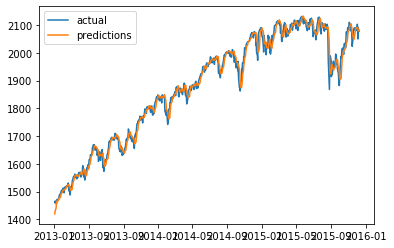

In [11]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

The mean absolute error using the regression model on features1 resulted in a MAE of 16.13. I will remove features to see if this error metric improves.

In [12]:
features2 = ['AvgRatioPrice','StdDevRatioPrice']
lr = LinearRegression()
lr.fit(train[features2],train['Close'])

predictions = lr.predict(test[features2])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)

1443.0391281718698


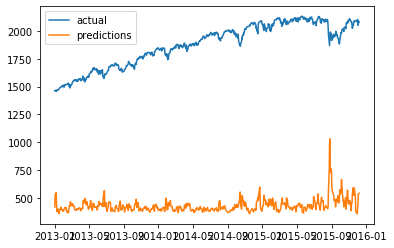

In [13]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

The MAE rose drastically from 16.13 to 1443.04, so our first set of features created a better model. I will now try to add more features to see if this could be reduced. 

In [14]:
features3 = ['FiveDayAvgPrice','YearAvgPrice','AvgRatioPrice','FiveDayStdDevPrice','YearStdDevPrice','StdDevRatioPrice','FiveDayAvgVol','YearAvgVol','AvgRatioVol']

lr = LinearRegression()
lr.fit(train[features3],train['Close'])

predictions = lr.predict(test[features3])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)

16.151903360296174


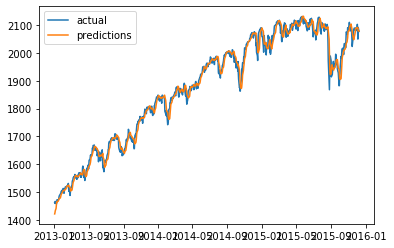

In [15]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

In [16]:
features4 = ['FiveDayAvgPrice','YearAvgPrice','AvgRatioPrice','FiveDayStdDevPrice','YearStdDevPrice','StdDevRatioPrice','AvgRatioVol']

lr = LinearRegression()
lr.fit(train[features4],train['Close'])

predictions = lr.predict(test[features4])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)

16.135369750885797


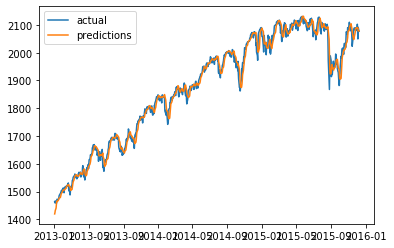

In [17]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

In [18]:
features5 = ['FiveDayAvgPrice','YearAvgPrice','AvgRatioPrice','FiveDayStdDevPrice','YearStdDevPrice','StdDevRatioPrice','Year','Month','Day']

lr = LinearRegression()
lr.fit(train[features5],train['Close'])

predictions = lr.predict(test[features5])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)

16.158514855118472


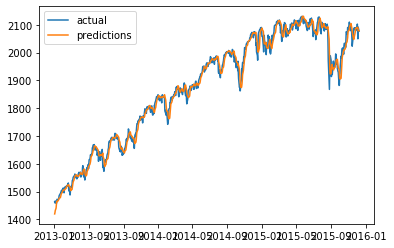

In [19]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

In [20]:
features6 = ['FiveDayAvgPrice','YearAvgPrice','AvgRatioPrice','FiveDayStdDevPrice','YearStdDevPrice','StdDevRatioPrice','Year','Month']

lr = LinearRegression()
lr.fit(train[features6],train['Close'])

predictions = lr.predict(test[features6])

mae = mean_absolute_error(predictions,test['Close'])

print(mae)

16.16022832826609


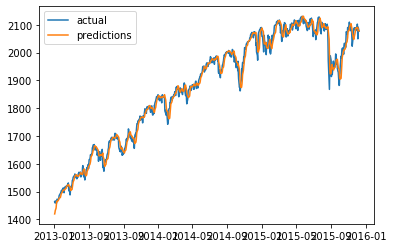

In [21]:
x = test.index
y1 = test['Close']
y2 = pd.Series(predictions)

plt.plot(x,y1,label='actual')
plt.plot(x,y2,label='predictions')
plt.legend()
plt.show()

## Conclusion

The error metric of the model has not improved so for future predictions, I would use the Linear Regression model fit with the first set of features, which resulted in a model with an MAE of 16.13.

## Improvements

I could perform more testing to see if any other combinations of features would perform better and could also make significant structural improvements to the algorithm, and pull in data from other sources.

Accuracy would improve greatly by making predictions only one day ahead. For example, train a model using data from 1951-01-03 to 2013-01-02, make predictions for 2013-01-03, and then train another model using data from 1951-01-03 to 2013-01-03, make predictions for 2013-01-04, and so on. This more closely simulates what I would do if I were trading using the algorithm.

I could also improve the algorithm used significantly. Try other techniques, like a random forest, and see if they perform better.

I could also incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks for example.

I could also make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.

Finally, I could make the system "higher-resolution". I am currently making daily predictions, but I could make hourly, minute-by-minute, or second by second predictions. This would require obtaining more data, though. I could also make predictions for individual stocks instead of the S&P500.